<a href="https://colab.research.google.com/github/Frussen/ita-load-forecaster/blob/main/ItaLoadForecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ItaLoadForecaster**
##**End-to-End Italian Electricity Load Forecasting PoC**

Progetto per forecasting del carico elettrico orario in Italia usando dati open (Open Power System Data).  
Obiettivo: Dimostrare pipeline ML completa (data prep → modeling → MLOps → dashboard) applicabile a clienti enterprise energy/utility.

### Business Value
- Riduzione errori forecast → ottimizzazione balancing, peak shaving, riduzione costi energia  
- ROI simulato: stima savings € basati su prezzi storici  
- Scalabile a predictive maintenance / anomaly detection su grid data

### Tech Stack
- Data: Pandas, NumPy  
- Viz: Matplotlib, Seaborn  
- Modeling: Prophet (baseline), LSTM (advanced)  
- Tracking: MLflow  
- Deployment: Streamlit + HuggingFace Spaces  
- Environment: Google Colab (free GPU)

### Dataset
Open Power System Data - Time Series (IT load, prices, renewables generation)

### 1. Business Context & Objectives

Il business context è...

### 2. Data Ingestion

In [2]:
# Install libs necessarie
!pip install prophet mlflow streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.3/788.3 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scarica dataset (versione 2020-10-06, la più stabile per il nostro scopo)
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
df = pd.read_csv(url)

In [5]:
# Stampa tutte le colonne per debug
print("Tutte le colonne disponibili nel dataset:")
print(df.columns.tolist())

Tutte le colonne disponibili nel dataset:
['utc_timestamp', 'cet_cest_timestamp', 'AT_load_actual_entsoe_transparency', 'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead', 'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual', 'BE_load_actual_entsoe_transparency', 'BE_load_forecast_entsoe_transparency', 'BE_solar_generation_actual', 'BE_wind_generation_actual', 'BE_wind_offshore_generation_actual', 'BE_wind_onshore_generation_actual', 'BG_load_actual_entsoe_transparency', 'BG_load_forecast_entsoe_transparency', 'BG_solar_generation_actual', 'BG_wind_onshore_generation_actual', 'CH_load_actual_entsoe_transparency', 'CH_load_forecast_entsoe_transparency', 'CH_solar_capacity', 'CH_solar_generation_actual', 'CH_wind_onshore_capacity', 'CH_wind_onshore_generation_actual', 'CY_load_actual_entsoe_transparency', 'CY_load_forecast_entsoe_transparency', 'CY_wind_onshore_generation_actual', 'CZ_load_actual_entsoe_transparency', 'CZ_load_forecast_entsoe_transparency', 'CZ_sol

In [6]:
# Colonne Italia aggregate + prezzo zona Nord (rappresentativo)
cols_it = [
    'utc_timestamp',
    'cet_cest_timestamp',
    'IT_load_actual_entsoe_transparency',          # Target: load nazionale
    'IT_load_forecast_entsoe_transparency',        # Forecast ufficiale (per confronto)
    'IT_NORD_price_day_ahead',                     # Prezzo day-ahead Nord (usato come exogenous principale)
    'IT_solar_generation_actual',
    'IT_wind_onshore_generation_actual'
]
df = df[cols_it].copy()

In [7]:
# Converti timestamp (come prima)
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df['cet_cest_timestamp'] = pd.to_datetime(df['cet_cest_timestamp'])

# Set index CET
df.set_index('cet_cest_timestamp', inplace=True)
df.sort_index(inplace=True)

# Drop righe con NaN nel target (load)
df = df.dropna(subset=['IT_load_actual_entsoe_transparency'])

print("Shape finale:", df.shape)
print(df.head())

Shape finale: (50398, 6)
                                      utc_timestamp  \
cet_cest_timestamp                                    
2015-01-01 02:00:00+01:00 2015-01-01 01:00:00+00:00   
2015-01-01 03:00:00+01:00 2015-01-01 02:00:00+00:00   
2015-01-01 04:00:00+01:00 2015-01-01 03:00:00+00:00   
2015-01-01 05:00:00+01:00 2015-01-01 04:00:00+00:00   
2015-01-01 06:00:00+01:00 2015-01-01 05:00:00+00:00   

                           IT_load_actual_entsoe_transparency  \
cet_cest_timestamp                                              
2015-01-01 02:00:00+01:00                             21534.0   
2015-01-01 03:00:00+01:00                             20219.0   
2015-01-01 04:00:00+01:00                             19470.0   
2015-01-01 05:00:00+01:00                             19485.0   
2015-01-01 06:00:00+01:00                             20349.0   

                           IT_load_forecast_entsoe_transparency  \
cet_cest_timestamp                                                

/tmp/ipython-input-1757204905.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['cet_cest_timestamp'] = pd.to_datetime(df['cet_cest_timestamp'])


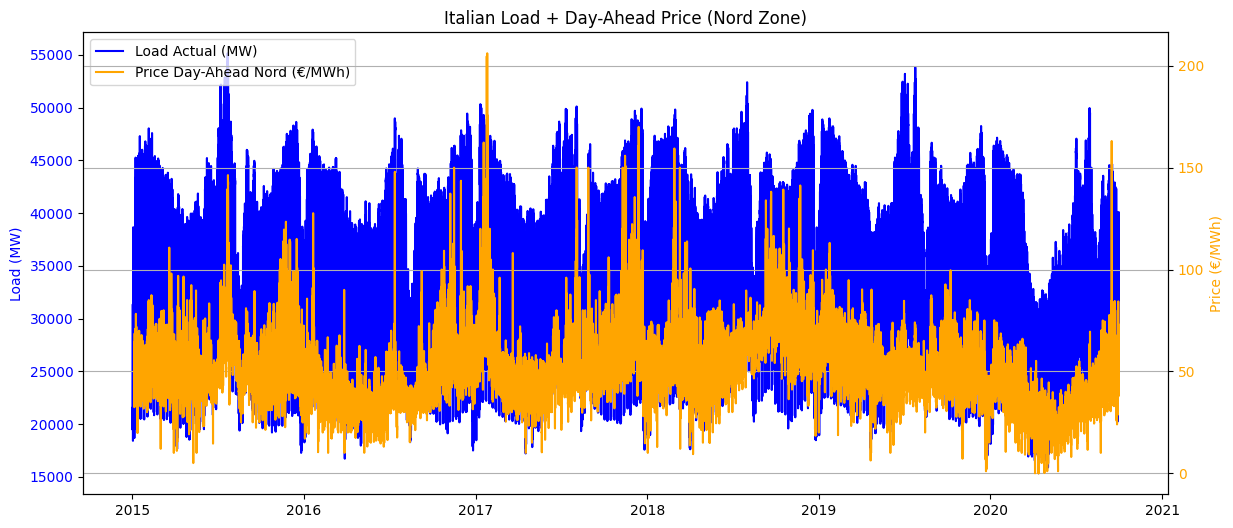

In [8]:
# Plot load + prezzo Nord per vedere correlazione
plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax1.plot(df.index, df['IT_load_actual_entsoe_transparency'], color='blue', label='Load Actual (MW)')
ax1.set_ylabel('Load (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['IT_NORD_price_day_ahead'], color='orange', label='Price Day-Ahead Nord (€/MWh)')
ax2.set_ylabel('Price (€/MWh)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Italian Load + Day-Ahead Price (Nord Zone)')
plt.grid(True)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.show()


### 3. Exploratory Data Analysis (EDA)


### 4. Feature Engineering


### 5. Baseline Model: Prophet


### 6. Advanced Model: LSTM


### 7. Model Evaluation & ROI Simulation


### 8. MLOps Tracking with MLflow


### 9. Deployment-ready Dashboard (Streamlit preview)


### 10. Next Steps & Production Path


### Appendix: Lessons Learned